Create environment:

```python
mamba create -n confocal python=3.10 matplotlib numba scipy notebook
mamba activate confocal
mamba install cupy # if you want

pip install psfmodels
# this one isn't on PyPI yet... and really doesn't have a stable API at all
pip install git+https://github.com/tlambert03/microsim.git
```

In [1]:
# using the private _cuvec module because it can use cupy if available
# though the public API is not yet stable
from psfmodels._cuvec import vectorial_psf_centered
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
import tqdm
import numpy as np

In [2]:
# convenience function we'll use a couple times
def ortho_plot(img, gamma: float = 0.5):
    """Plot XY and XZ slices of a 3D array."""
    _, ax = plt.subplots(ncols=2, figsize=(10, 5))
    ax[0].imshow(img[img.shape[0] // 2], norm=PowerNorm(gamma))
    ax[1].imshow(img[:, img.shape[1] // 2], norm=PowerNorm(gamma))
    ax[0].set_title("XY slice")
    ax[1].set_title("XZ slice")

There is a function to generate confocal PSFs in psfmodels `psfmodels.confocal_psf`...
but it's not setup to take advantage of the GPU, so is still slow.

The function below is much faster, and can be upstreamed eventually.

In [3]:
try:
    from cupyx.scipy.signal import fftconvolve
    import cupy as xp
except ImportError:
    import numpy as xp
    from scipy.signal import fftconvolve

def make_confocal_psf(ex_wvl=0.475, em_wvl=0.525, pinhole_au=1.0, **kwargs):
    """Create a confocal PSF.
    
    This function creates a confocal PSF by multiplying the excitation PSF with
    the emission PSF convolved with a pinhole mask.
    
    All extra keyword arguments are passed to `vectorial_psf_centered`.
    """
    kwargs.pop("wvl", None)
    params: dict = kwargs.setdefault("params", {})
    na = params.setdefault("na", 1.4)
    dxy = kwargs.setdefault("dxy", 0.01)

    print("making excitation PSF...")
    ex_psf = vectorial_psf_centered(wvl=ex_wvl, **kwargs)
    print("making emission PSF...")
    em_psf = vectorial_psf_centered(wvl=em_wvl, **kwargs)

    # The effective emission PSF is the regular emission PSF convolved with the
    # pinhole mask. The pinhole mask is a disk with diameter equal to the pinhole
    # size in AU, converted to pixels.
    pinhole = _pinhole_mask(
        nxy=ex_psf.shape[-1], pinhole_au=pinhole_au, wvl=em_wvl, na=na, dxy=dxy
    )
    pinhole = xp.asarray(pinhole)

    print("convolving em_psf with pinhole...")
    eff_em_psf = np.empty_like(em_psf)
    for i in tqdm.trange(len(em_psf)):
        plane = fftconvolve(xp.asarray(em_psf[i]), pinhole, mode="same")
        eff_em_psf[i] = plane.get() if hasattr(plane, 'get') else plane

    # The final PSF is the excitation PSF multiplied by the effective emission PSF.
    return ex_psf * eff_em_psf

def _pinhole_mask(nxy: int, pinhole_au: float, wvl: float, na: float, dxy: float):
    """Create a 2D circular pinhole mask of specified `pinhole_au`."""
    pinhole_size = pinhole_au * 0.61 * wvl / na
    pinhole_px = pinhole_size / dxy

    x = xp.arange(nxy) - nxy // 2
    xx, yy = xp.meshgrid(x, x)
    r = xp.sqrt(xx**2 + yy**2)
    return (r <= pinhole_px).astype(int)


Here's an example of creating and viewing a basic PSF

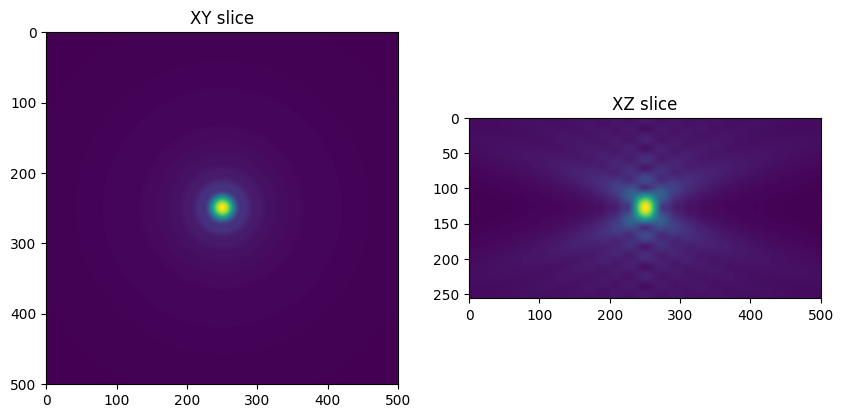

In [4]:
# create 1025^3 PSF with (20, 10, 10) nm voxel size
psf = vectorial_psf_centered(
    nz=257, nx=501, dz=0.02, dxy=0.01, wvl=0.525, params={"na": 1.4}
)
ortho_plot(psf)

... and here's a variant using a pinhole of 1AU

making excitation PSF...

making emission PSF...

convolving em_psf with pinhole...

100%|██████████| 257/257 [00:08<00:00, 31.04it/s]


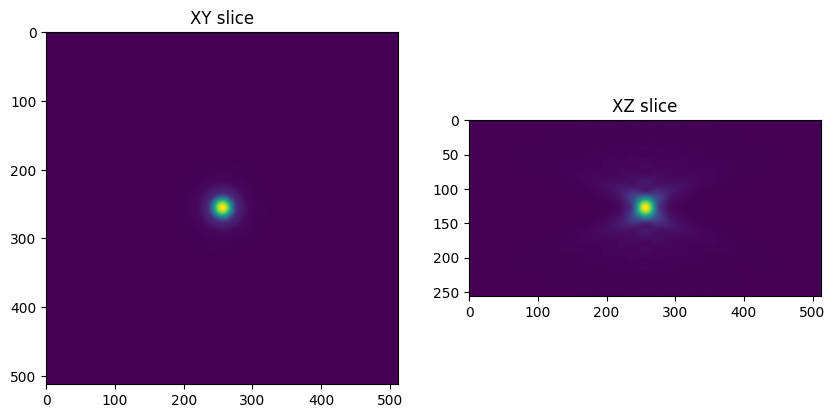

In [5]:
psf_1au = make_confocal_psf(
    ex_wvl=0.475,
    em_wvl=0.525,
    pinhole_au=1,
    nz=257,
    nx=513,
    dz=0.02,
    dxy=0.01,
    params={"na": 1.4},
)
ortho_plot(psf_1au)

Now, all we need to do to create an image is to convolve the PSF with
some ground truth sample.  Here's where we can get creative...

To start with, here's some lines in random 3D orientations and lengths
(I call it "mats lines" because it's similar to a pattern mats gustafsson used 
in the supplement of a paper)

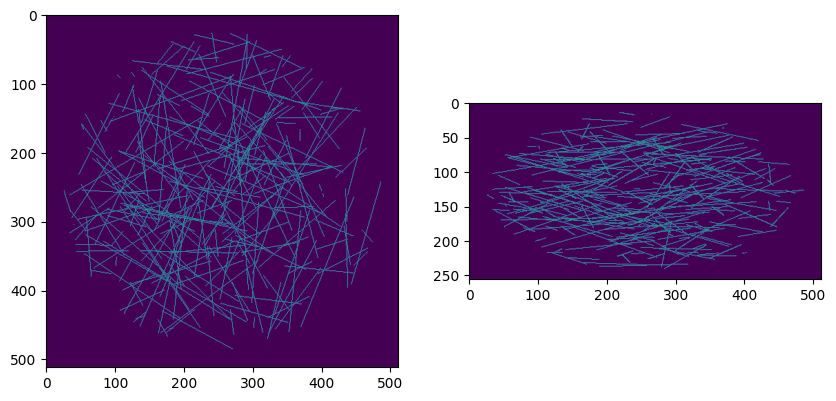

In [6]:
from microsim.samples import MatsLines

ary = np.zeros((256, 512, 512))
mats = MatsLines(density=1, length=8, azimuth=10, max_r=0.9)
truth = mats.render(ary)

# plot max projection
_, axs = plt.subplots(ncols=2, figsize=(10, 5))
axs[0].imshow(truth.max(axis=0))
axs[1].imshow(truth.max(axis=1))

And now to create an optical section, we the truth with a PSF:

this is where it can get really slow, and requires a lot of VRAM to do it on the GPU...
You can try using `cupyx.scipy.signal.fftconvolve`...
you'll need to recast the arrays as `cupy.ndarray` first:

```py
from cupyx.scipy.signal import fftconvolve

img = signal.fftconvolve(xp.asarray(truth), xp.asarray(psf), mode="same")
```

below we just do it on the CPU


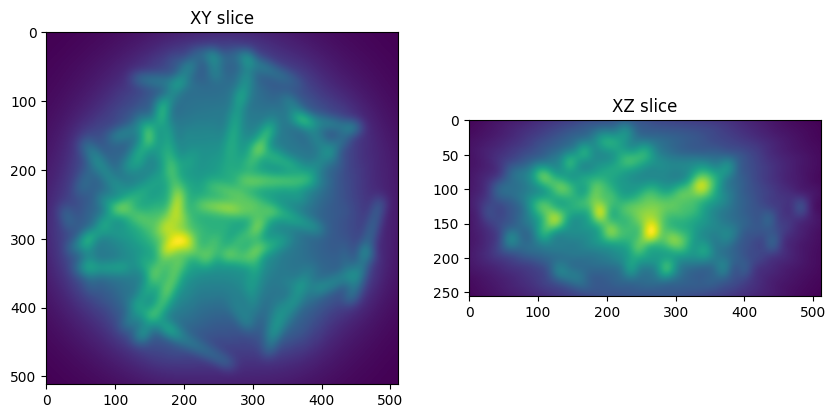

In [12]:
from scipy import signal

img_wf = signal.fftconvolve(truth, psf, mode="same")
ortho_plot(img_wf, gamma=1)

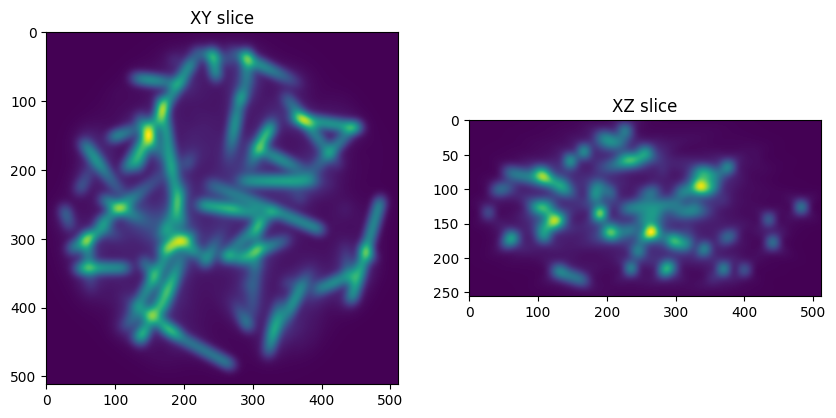

In [13]:
# same thing, but for the confocal PSF
img_confocal = signal.fftconvolve(truth, psf_1au, mode="same")
ortho_plot(img_confocal, gamma=1)

Lastly, you might want to downsample it to a more realistic dxy/dz sampling rate

In [9]:
from typing import Sequence

def downsample(
    array: np.ndarray, factor: int | Sequence[int], method=np.sum, dtype=None
) -> np.ndarray:
    binfactor = (factor,) * array.ndim if isinstance(factor, int) else factor
    new_shape = []
    for s, b in zip(array.shape, binfactor):
        new_shape.extend([s // b, b])
    reshaped = np.reshape(array, new_shape)
    for d in range(array.ndim):
        reshaped = method(reshaped, axis=-1 * (d + 1), dtype=dtype)
    return reshaped

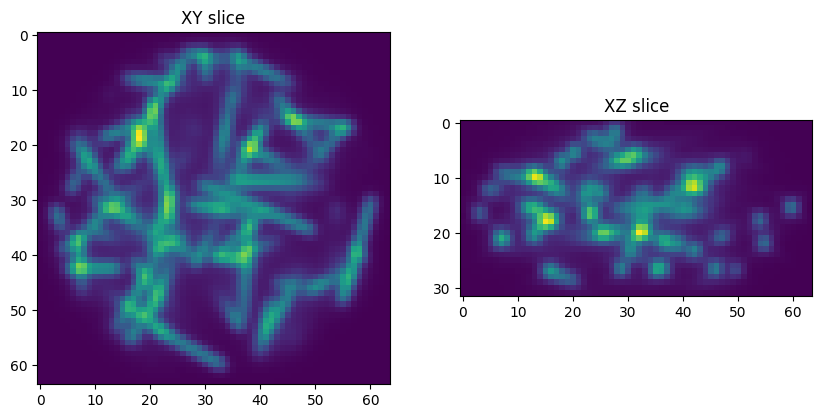

In [14]:
# since we started at 20nm z and 10nm xy, we can downsample by 8x
# to get something realistic

downsampled_img = downsample(img_confocal, 8)
ortho_plot(downsampled_img, gamma=1)

Now you can add noise however you want... but microsim has a function for that too:

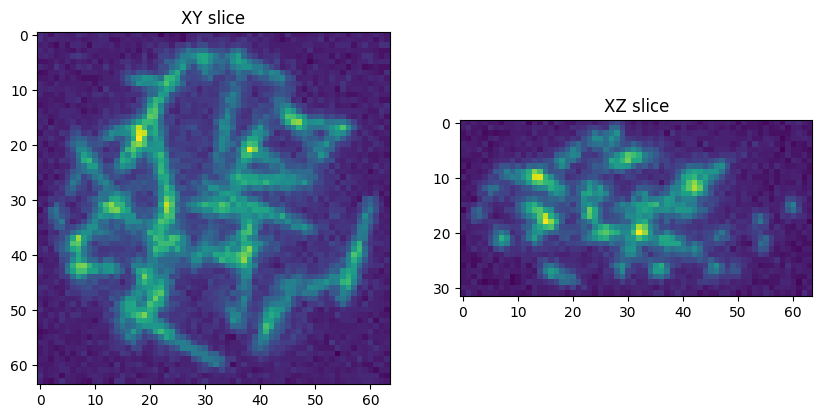

In [15]:
from microsim.models import Camera

camera = Camera(
   qe=0.82,
   gain=1,
   full_well=18000,  # e
   dark_current=0.0005,  # e/pix/sec
   clock_induced_charge=1,
   read_noise=6,
   bit_depth=12,
   offset=100,
   # not used here
   readout_rate=1,
   photodiode_size=1,
   )

max_photons_pp_ps = 2000
photons = max_photons_pp_ps * downsampled_img / downsampled_img.max()
noised = camera.simulate(photons, exposure=0.2)
ortho_plot(noised, gamma=1)